In [1]:
import os 
import datetime as dt
from datetime import datetime
import pandas as pd
import random
import bqplot
import numpy as np
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib.image as img 
import json
from pandas.io.json import json_normalize

import matplotlib.colors as mpl_colors
import seaborn as sns

%matplotlib inline

<h1><center> Visualization of Google Store Transaction Revenue </center></h1>


<center>Author: Chuyi Wang</center>


<dl>
    <dt>1. Exploration of the overall distritbuion of Transaction Revenue</dt>
    <dd>For e-commerce or only store, it is important to keep moniter as well as do ad-hoc analysis about the transaction revenue. There are mainly two points. The first one it is that the business profitability could be significantly improved and optimized throught the big data analysis. Besides, it is more convenient to get the data since all transactions are completed online.</dd>
</dl>

In [2]:
df_train = pd.read_csv('train_cleaned.csv',low_memory=False)
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_train['visitHour'] = (df_train['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)


In [3]:
#validate the 80-20 assumption
df_user = df_train.groupby(['fullVisitorId'])['totals.transactionRevenue'].sum().reset_index()
df_user.loc[df_user['totals.transactionRevenue']>0, 'payment_success']='Payment Success'
df_user.loc[df_user['totals.transactionRevenue']==0, 'payment_success']='No Payment'

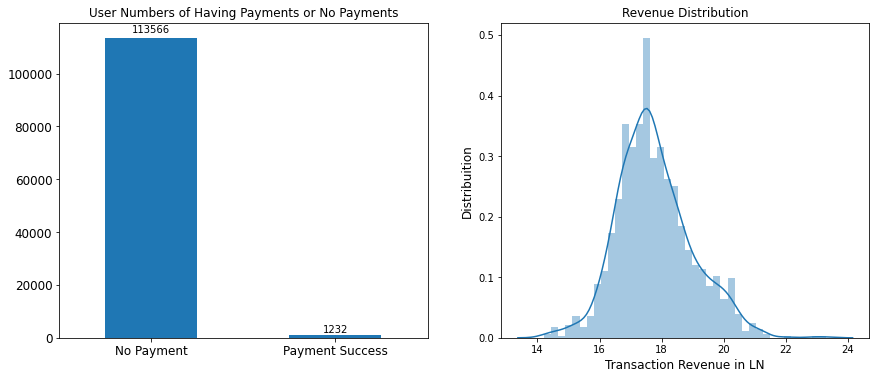

In [4]:
plt.figure(figsize=(6,5))
plt.subplots_adjust(right=2, top=1)
plt.subplot(1,2,2)
#figsize=(10,6)
ax = sns.distplot(np.log(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction Revenue in LN', fontsize=12) #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize=12) #seting the ylabel and size of font
ax.set_title('Revenue Distribution',fontsize=12)

plt.subplot(1,2,1)
ax=df_user['payment_success'].value_counts().plot(kind='bar',  title='User Numbers of Having Payments or No Payments',fontsize=12)
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, 1.01*height,
            '%d' % int(height), ha='center', va='bottom')
    plt.xticks(rotation=0)
plt.show()

Based on the Pareto principle(also known as the 80/20 rule), only a small fraction of the population will affect the results of interest. It could be proved by the left graph, which show the frequencies of visits with payments and vistits without any payments. Actually, only 1.27% of the total visis in this data have the transaction revenues larger than 0. 

To explore the distribution of the transacion revenues which are larger than 0, it would be better to transform it to the log(e) format since the distribution is very sparse. It is good to be seen that, the log distritbuion looks close to a normal distribution. The property is going to be very useful when doing the prediction.

<dl>
    <dt>2. Exploration of the distritbuion of Transaction Revenue over time</dt>
    <dd>The retail industry could fluctuate widely and affected by a large amount of factors. A common factor is the time. For example, the sales usually fall into a seasonal pattern. It will be helpful to explore the revenue trends over time and adjust it for the following analysis</dd>
</dl>

In [5]:
#validate the 80-20 assumption
df_user = df_train.groupby(['fullVisitorId'])['totals.transactionRevenue'].sum().reset_index()
df_user.loc[df_user['totals.transactionRevenue']>0, 'payment_success']='Payment Success'
df_user.loc[df_user['totals.transactionRevenue']==0, 'payment_success']='No Payment'

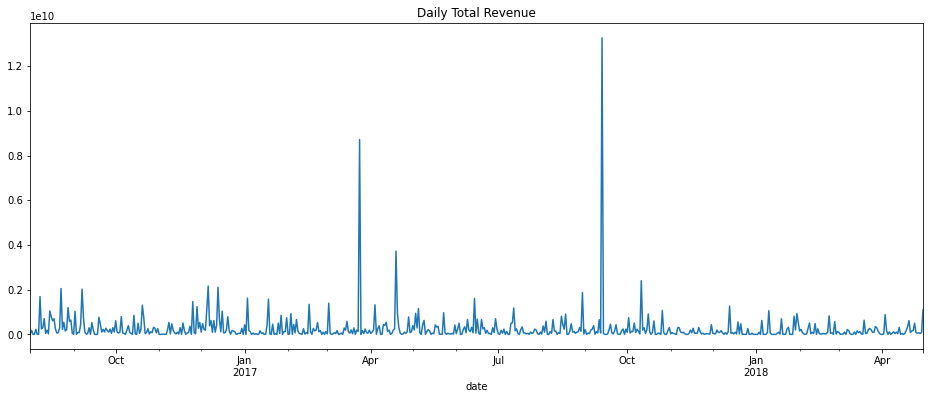

In [6]:
df_train.groupby(['date'])['totals.transactionRevenue'].sum().plot(figsize=(16,6), title = 'Daily Total Revenue')

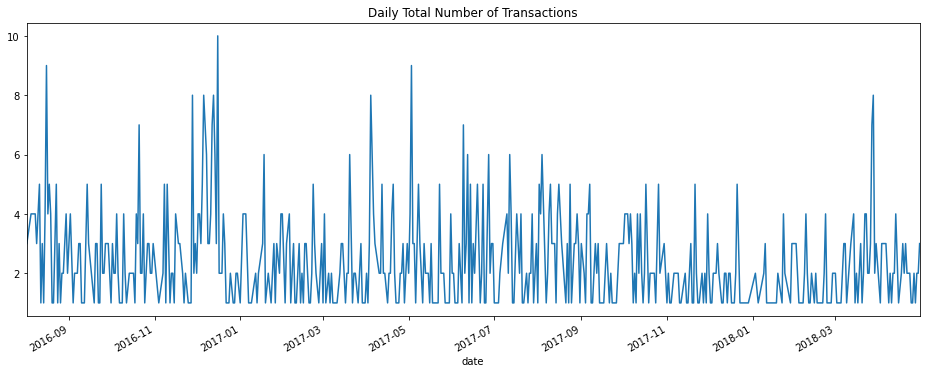

In [7]:
df_train[df_train['totals.transactionRevenue']>0].groupby(['date'])['totals.transactionRevenue'].count().plot(figsize=(16,6),title = 'Daily Total Number of Transactions')

Through the above two graphs, the first thing could be found that they are both very wiggly. It is mainly because the revenues and visits are largely affected by the time series or time factors, such as days of the week, weeks of the months, month, seasons. Besides, it could be found that, the numbers of daily transactions and the number of daily revenue are not always aligned with each other. This indicates that the range of transcation revenues might substantially vary across different dates.

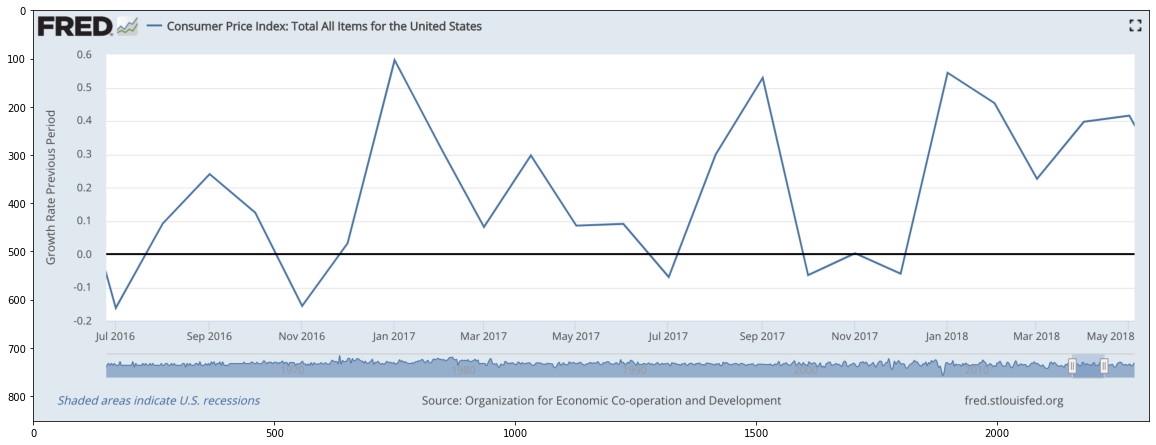

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
im_CPI = img.imread('US_CPI.png')  
ax.imshow(im_CPI)
plt.show()

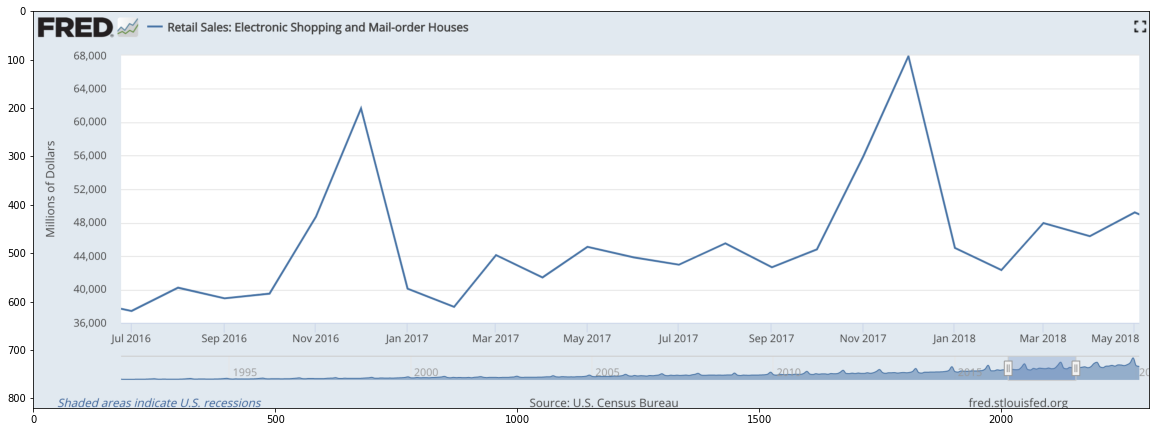

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
im_industry = img.imread('US_Ecommerce.png')  
ax.imshow(im_industry)
plt.show()

The above two contextual data visualization are from the Federal Reserve Bank of St.Louis (https://fred.stlouisfed.org/), which are somehow helpful to provide the relevant market bench mark or information about the consumers prices and overall e-commerce trends in the market over time. So if there is any conflict between the Google stores and the market, it is worth more attention to dig into it. 

<dl>
    <dt>3. Exploration of the overall distritbuion of Transaction Revenue</dt>
    <dd>For e-commerce or only store, it is important to keep moniter as well as do ad-hoc analysis about the transaction revenue. There are mainly two points. The first one it is that the business profitability could be significantly improved and optimized throught the big data analysis. Besides, it is more convenient to get the data since all transactions are completed online.</dd>
</dl>

This is a quite larger dataset and the transaction revenue is the variable of most interest and overall target goal. It is important to visualize how the other factors affect the transaction revenue over time.

The first dashboard called "Global Transaction" helped us to see the transaction amount over time in a geographical world map. By moving the mouse cursor in the map, it would automatically show a dynamic pop-up window, which give the line plot of the daily transaction revenue of the country over time when the cursor is hovering on a given country. If there are non-records, or only non-payment records, that is non transaction revenue at all, or number of records less than 10, the pop-up window will be empty while with a statement saying "No enough data or No data available at all" in the country. Through the plot we could find that most of the transacions are from the north America.


In [10]:
from ipywidgets import Label, VBox, Layout
from bqplot.market_map import MarketMap
from bqplot import (ColorScale, ColorAxis, DateScale, 
                    LinearScale, Axis, Lines, Figure)


In [11]:
df_train_daily = df_train.groupby(['geoNetwork.country','date'])['totals.transactionRevenue'].sum().reset_index()
#df_train_daily['date'].nunique()

**Dashboard 3.1**

In [12]:
## Create Line Plot Elements for the dynamic pop-up for the country where the cursor land
sc_x = DateScale()
sc_y = LinearScale()

ax_x = Axis(scale=sc_x, grid_lines='dashed', label='Date')
ax_y = Axis(scale=sc_y, orientation='vertical', grid_lines='dashed',
            label='Transaction Revenue', label_location='end', label_offset='-1em')

# line = Lines(x= np.array(sorted(df_train_daily['date'].unique())), 
#              y=[], scales={'x': sc_x, 'y': sc_y}, colors=['orange'])
line = Lines(x=[], 
             y=[], scales={'x': sc_x, 'y': sc_y}, colors=['orange'])
line.layout = Layout(width='200px', height='150px')
fig_tooltip = Figure(marks=[line], axes=[ax_x, ax_y])
fig_tooltip.layout = Layout(width='500px', height='450px')

In [13]:
#define the map and how it displays with the df_train as the input data. 
# scales
sc_geo = bqplot.Mercator() # a projection from the globe (sphere) onto a plane 
# "axis"
shape_data = bqplot.topo_load('map_data/WorldMap.json')

# marks
shape_map = bqplot.Map(map_data=shape_data, scales={'projection':sc_geo},tooltip=fig_tooltip)


map_mark = bqplot.Map(scales={'projection': bqplot.Mercator()}, tooltip=fig_tooltip)
map_mark.interactions = {'click': 'select', 'hover': 'tooltip'}
map_mark.layout = Layout(min_width='800px', min_height='800px')
#fig =bqplot.Figure(marks=[map_mark], title='Interactions Example')

# Update the tooltip chart
hovered_symbol = {}
def hover_handler(self, content):
    global hovered_symbol
    symbol = content.get('data', '')
#     print('symbol' ,symbol)
#     print('hovered_symbol',hovered_symbol)
    
    if(symbol != hovered_symbol):
        hovered_symbol = symbol
#        print(hovered_symbol['name'])
        #print(df_train_daily[df_train_daily['geoNetwork.country']==hovered_symbol['name']])
#         sub_country = df_train_daily[df_train_daily['date']>= from_date  & df_train_daily['date']<= end_date]
        sub_country = df_train_daily[df_train_daily['geoNetwork.country']==hovered_symbol['name']]
        if sub_country['totals.transactionRevenue'].nunique() > 1 and len(sub_country)>20:
            with line.hold_sync():
                line.x = sub_country['date'].values
                line.y = sub_country['totals.transactionRevenue'].values
                line.scales['y'].min = line.y.min().item()
                line.scales['y'].max = line.y.max().item()
#                print(sub_country['date'].values)
                print(hovered_symbol['name'])
                print('Total Days with transactions:' , len(line.x))
                print('Min Trasaction Revenue:', line.y.min().item())
                print('Max Trasaction Revenue:', line.y.max().item())
 

            fig_tooltip.title = hovered_symbol['name']
        else:
            with line.hold_sync():
                line.x = []
                line.y = []
                fig_tooltip.title = 'No enough data for '+hovered_symbol['name']

map_mark.on_hover(hover_handler)
fig=bqplot.Figure(marks=[map_mark], title='Global Transactions')
fig

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, marks=[Map(hovered_styles={'hovered_fill…

**Dashboard 3.2**

In [14]:
agg_vars=['day','week','month']
group_vars=['channelGrouping', 'device.isMobile','trafficSource.isTrueDirect', 
            'device.deviceCategory', 'geoNetwork.continent','None']

@ipywidgets.interact(aggregation_level=agg_vars,group_by=group_vars)
def plot_timeseries_revenue(aggregation_level, group_by):
#     fig_size = (14, 8)
#     fig, ax = plt.subplots(figsize=fig_size)
#     plt.title(aggregation_level +' Trasaction Revenue', fontsize=18)
#     plt.ylabel('Transaction Revenue in Dollars ($)', fontsize=14)
    
    if aggregation_level in ['week', 'month']:
        if aggregation_level=='week':
            #df_train['week'] = df_train['date'] - df_train['date'].dt.dayofweek*timedelta(days=1)
            df_train['week'] = df_train['date'].values.astype('datetime64[W]')
        elif aggregation_level=='month':
            #df_train['month'] = df_train['date'].dt.year*100 + df_train['date'].dt.month
            df_train['month'] = df_train['date'].values.astype('datetime64[M]')
    else:
        #df_train['day'] = df_train['date'].dt.year*10000 + df_train['date'].dt.month*100+df_train['date'].dt.day
        df_train['day']= df_train['date'].dt.date
  
    if group_by == 'None':  
        fig_size = (14, 8)
        fig, ax = plt.subplots(figsize=fig_size)
        plt.title(aggregation_level +' Trasaction Revenue', fontsize=18)
        plt.ylabel('Transaction Revenue in Dollars ($)', fontsize=14)       
        df_train.groupby([aggregation_level]).sum()['totals.transactionRevenue'].plot(ax=ax)
    else:
        fig, axes = plt.subplots(1, 2)
        plt.subplots_adjust(right=2.5, top=1.5)
        for i in range(2):
            ax=axes[i]
            if i==0:
                #plt.subplots(1, 2, i)
                #plt.figure(figsize=(8,8))
                ax.set_ylabel(aggregation_level +' Trasaction Revenue', fontsize=14)  
                df_train.groupby([aggregation_level, group_by]).sum()['totals.transactionRevenue'].unstack().plot(ax=ax)
            else:
                #fig, ax= plt.subplots(1, 2, i)
                ax.set_ylabel('Total Transaction Revenue in Dollars ($)', fontsize=14) 
                df_train.groupby([group_by]).sum()['totals.transactionRevenue'].plot(ax=ax, kind='bar')
        

interactive(children=(Dropdown(description='aggregation_level', options=('day', 'week', 'month'), value='day')…

The second dashboard gives two graphs horizontally. The left one reveals the trends of transaction revenue over different time levels ('day', 'week', 'month') and grouped by different categorical factors, that is ('channelGrouping', 'device.isMobile','trafficSource.isTrueDirect', 'device.deviceCategory', 'geoNetwork.continent'). Especially, in additional to the existing varaibles in the data, 'None' is also an option for users to check the overall revenue trends over different time levels. So there are two scolled-down list from ipywidget interact, which allows the user to choose the time levels for x axis and grouped-by variables. The y-axis is always indicating the transaction revenue in dollars. 

The right one get rids of the time factor and has indicate the distribution of revenues across the groups within each viriables. And there are a lot interesting findings after further breaking down the revenue by different varaibles. For example, by selecting 'device.isMobile' in the group_by scoll-down list, it could be cound that most of the revenue are still from the non-mobile devices. 